# Handle imports

In [1]:
from dotenv import load_dotenv
import os
import cassio
from uuid import uuid4
import numpy as np
import pandas as pd
import json
import pandas as pd


from typing import Literal,List,Annotated

from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage,trim_messages,AIMessage,HumanMessage,RemoveMessage
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import add_messages

from typing_extensions import TypedDict

from transformers import BertTokenizer,BertModel
import pickle as pkl

load_dotenv()

d:\TAMU\SEM 4\CNM\BrokenBasket\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

In [2]:
unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY') # Update to your API key
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv('HUGGINGFACEHUB_API_TOKEN')
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY') # Update to your API key if using OpenAI
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
# groq_api_key = os.getenv('GROQ_API_KEY')


In [3]:
from langsmith import Client
client = Client()

# Connect to the database

In [4]:
# ingredients_db = pkl.load(open('Dataset/preprocessed_data_with_embeddings.pkl', 'rb'))
ingredients_db = pkl.load(open('Dataset/calories_embedded.pkl', 'rb'))

In [5]:
ingredients_db.head()

,FoodCategory,FoodItem,per100grams,Cals_per100grams,embedding
0,CannedFruit,Applesauce,100g,62 cal,"[[-0.24007308, 0.09068904, -0.057347823, -0.08..."
1,CannedFruit,Canned Apricots,100g,48 cal,"[[-0.20948026, -0.038242195, -0.51229817, 0.26..."
2,CannedFruit,Canned Blackberries,100g,92 cal,"[[-0.42622027, 0.15006654, -0.5919996, 0.18029..."
3,CannedFruit,Canned Blueberries,100g,88 cal,"[[-0.36144668, 0.17941771, -0.47740045, 0.3089..."
4,CannedFruit,Canned Cherries,100g,54 cal,"[[-0.16118407, 0.20291516, -0.28830114, 0.3585..."


In [6]:
# connection of Astra DB
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id = ASTRA_DB_ID
)

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [8]:
from langchain.vectorstores import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name = "CNM_test_table",
                               session=None,
                               keyspace=None)

In [9]:
recipe_retriever = astra_vector_store.as_retriever(    
                                                search_type="similarity_score_threshold",
                                                search_kwargs={"k": 7, "score_threshold": 0.6},
                                                )   
recipe_retriever.invoke("Give me a cookie recipe")

[Document(id='423043d548c040abbdbc0ebaa6b1221e', metadata={'seq_num': '3978.0', 'source': 'D:\\TAMU\\SEM 4\\CNM\\BrokenBasket\\Dataset\\recipe.json'}, page_content='{"directions": ["Preheat oven to 375\\u00b0F. Butter heavy large cookie sheets. Beat vegetable shortening and unsalted butter in large bowl until light. Gradually add white and brown sugars and beat mixture until fluffy. Add eggs 1 at a time, beating well after each addition. Add vanilla pudding mix, vanilla extract, baking soda, water, ground cinnamon, ground nutmeg and salt and mix until well blended. Mix in oats, then flour. Stir in chocolate chips and walnuts.", "Drop cookie dough by large rounded spoonfuls (about 3 tablespoons each) onto prepared cookie sheets, spacing 2 inches apart. Bake until cookies appear dry and tops are lightly cracked and soft when pressed, about 12 minutes (do not overbake). Cool cookies 5 minutes on cookie sheets. Transfer cookies to racks and cool. (Store cookies in airtight container.)"], "

# Langgraph

### Datamodel

In [10]:
class GeneralRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["food","general"] = Field(
        ...,
        description="Given a user question choose to route it to general chat or a food"
    )

class ToolRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["meal_plan","recipe"] = Field(
        ...,
        description="Given a user question choose to route it to meal_plan or recipe"
    )

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: recent message history
        preferences: uses' food preferences
        documents: list of documents
        calorie_goal: user's calorie goal
    """
    messages: Annotated[list[AnyMessage], add_messages]
    documents: List[str]
    preferences: str
    calorie_goal: int
    meal_plan: dict
    redo: str
    current_calories : int

### LLM links

In [11]:
# llm=ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')
# chat_llm = ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')

# structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
# structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)


In [12]:
# from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

# llm_link = HuggingFaceEndpoint(
#     repo_id="mistralai/Mistral-7B-Instruct-v0.3",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )

# llm = ChatHuggingFace(llm=llm_link)
# chat_llm = ChatHuggingFace(llm=llm_link)


# structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
# structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)

In [13]:
llm = ChatOpenAI(model = "gpt-4o-mini")
chat_llm = ChatOpenAI(model = "gpt-4o-mini")

structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)

d:\TAMU\SEM 4\CNM\BrokenBasket\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1624: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


### Prompts

In [14]:
# General router Prompt
system = """You are an expert at routing a user question to a food or general.
The food can tools to take care of meal planning, recipe finding and creation.
Use the food for questions on these topics. Otherwise, use general."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_router = route_prompt | structured_llm_general_router

# print(general_router.invoke({"messages": "what is stardew Valley"}))
# print(general_router.invoke({"messages": "How to make a sweet dessert"}))

In [15]:
# tool router Prompt
system = """
You are an expert at routing a user message to a meal_plan or recipe.
the meal_plan has access to tools to generate a meal plan for your weight goals.
Use the meal_plan for questions on these topics. 
If the message has to do with finding or modifying a recipe, use recipe.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

tool_router = route_prompt | structured_llm_tool_router

# print(tool_router.invoke({"messages": "how to make butter chicken"}))
# print(tool_router.invoke({"messages": "help me plan the food for the week"}))

In [ ]:
# General Chat Prompt
system = """You are a helpful health coach that answers questions to the best of your ability.
Here is the information you have about the user:
preferences: {preferences} 
calorie_goal: {calorie_goal}
meal_plan: {meal_plan}
"""
general_chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_chat = general_chat_prompt | chat_llm

In [17]:
temp_docs = """
[Document(id='d61c2d48df544d9ab1ec4f56b13f4aaa', metadata={'language': 'en-US', 'source': 'https://www.loveandlemons.com/wprm_print/best-homemade-brownies', 'title': 'Best Homemade Brownies - Love and Lemons'}, page_content="Best Homemade Brownies - Love and Lemons     \nGo Back\nPrintRecipe ImageNotes–+\xa0servingsSmallerNormalLargerBest Homemade BrowniesPrep Time: 5 minutes minsCook Time: 45 minutes minsServes 16 browniesThe ultimate recipe for brownies! They're fudgy, moist, and super chocolaty, with perfect crispy edges. From Weeknight Baking by Michelle Lopez.Equipment8x8 Baking Dish (this is the one I use so they don't overcook)Cooking Spray (I love this avocado oil one from Chosen Foods)Parchment Paper (this makes it so much easier to remove the brownies from the pan)Ingredients1 1/2 cups granulated sugar*3/4 cup all-purpose flour2/3 cup cocoa powder, sifted if lumpy1/2 cup powdered sugar, sifted if lumpy1/2 cup dark chocolate chips3/4 teaspoons sea salt2 large eggs1/2 cup canola oil or extra-virgin olive oil**2 tablespoons water1/2 teaspoon vanillaInstructionsPreheat the oven to 325°F. Lightly spray an 8x8 baking dish (not a 9x9 dish or your brownies will overcook) with cooking spray and line it with parchment paper. Spray the parchment paper.In a medium bowl, combine the sugar, flour, cocoa powder, powdered sugar, chocolate chips, and salt.In a large bowl, whisk together the eggs, olive oil, water, and vanilla.Sprinkle the dry mix over the wet mix and stir until just combined.Pour the batter into the prepared pan (it'll be thick - that's ok) and use a spatula to smooth the top. Bake for 40 to 48 minutes, or until a toothpick comes out with only a few crumbs attached (note: it's better to pull the brownies out early than to leave them in too long). Cool completely before slicing.*** Store in an airtight container at room temperature for up to 3 days. These also freeze well!Notes*If you'd like to reduce the sugar, I've had success with 1 cup granulated sugar instead of 1 1/2 cups.\n**I like to use olive oil because it's what I keep on hand and I enjoy the pairing of olive oil with chocolate. Keep in mind that you will taste it here. For a more neutral flavor, use canola oil.\n***When these brownies come out of the oven, they'll be super gooey in the middle. Allow them to cool completely, about 2 hours, before you slice into them to give them a chance to set up. They'll continue to firm up the longer they're out of the oven. If you still prefer a firmer brownie, store them in the fridge.Find it online at https://www.loveandlemons.com/brownies-recipe/"),
 Document(id='0a5a899762784e62804702b8cc9a6b95', metadata={'description': "This easy cake recipe requires just 7 ingredients and tastes like you spent hours making it, even though it's out of the oven in under an hour.", 'language': 'en', 'source': 'https://www.allrecipes.com/recipe/17481/simple-white-cake/?print', 'title': 'Simple White Cake Recipe'}, page_content="Worth the effort\nVery light, very great. This is my second time trying this recipe and it turned out just as amazing as the first time. Very beginner friendly, today I added some nuts on top. \n\n \n05\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nSayeh Majzoob\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n04/24/2024\nSince I was short of time, I swapped butter with high quality sun flower oil, and also reduced the sugar a tiny bit. I made it in less than 10 minutes and baked it for 40 mins. It turned out amazing, served with blueberry jam and some fresh strawberries. Since it is simple bake its taste will surely highly depend on the quality of the ingredients. Use tasty starting materials. I creamed the egg and sugar thourougly. \n\n \n06\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nPerkyBao1282\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n04/13/2024\n\n\n\nEasy to follow\n\n\n\nWorth the effort\n\n\n\nCrowd-pleaser\nThis is the third time I'm making this recipe. I love it \n\n \n07\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nEagerFlour9876\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n02/29/2024\n\n\n\nA keeper!\n\n\n\nCrowd-pleaser\n\n\n\nEasy to follow\n\n\n\nWorth the effort\nI LOVED this recipe. It was quick easy and it was just overall great. I loved the flavor and so did my family. The texture and consistency was perfect. We used it for the Leap Day Party cake. I will definitely make this again. \n\n \n08\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\ncatzrule1990\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n02/25/2024\n\n\n\nWorth the effort\n\n\n\nEasy to follow\n\n\n\nGreat flavors\n\n\n\nA keeper!\n\n\n\nCrowd-pleaser\n\n\n\nFamily favorite\nBeen trying to find a simple vanilla/white cake for a long time that didn't involve egg whites/whipping egg whites. This cake fits the bill! it has a wonderful flavor and texture. Not fragile, but not too dense. Stands up just fine with two layers. It is lovely with or without frosting! I decided to make a buttercream frosting with very subtle strawberry flavor and both the frosting and cake compliment each other very well. I would also imagine that this cake would be perfect to use for strawberry shortcake!Definitely a new keeper recipe for me! Dad and I love it very much. 10/10 \n\n \n09\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nMintPulp1911\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n01/07/2024\nI made this cake for my family and they loved it so much. Would definitely recommend \n\n \n10\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nGoldenParm7351\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n01/02/2024\nWas very delicious and fluffy. Totally recommend using this recipe. \n\n\n1\n\n\n2\n\n\n3\n\n\n4\n\n\n5\n\n\n\nNext\n\n\n\n\n\n\n \n\n\n\n\n\nYou’ll Also Love\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nWedding Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n161\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nEasy Birthday Cake\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nCream Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n177\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nSmash Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n2\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nHeavenly White Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n973\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nNany's White Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n136\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nLori's White Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n28\n\nRatings\n\n\n \n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\nMock Angel Food Cake\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n55\n\nRatings"),
 Document(id='f221c87e5852447eaca5168f2e4349be', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-soft-chocolate-chip-cookies/print/39213', 'title': 'The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum'}, page_content='Keywords: chocolate chip cookies, best chocolate chip cookies, soft chocolate chip cookies, easy cookie recipe, small batch cookies\n\n\n\n\n\nDid you make this recipe?\nTag\xa0@pinchofyum\xa0on Instagram so we can admire your masterpiece!\xa0🌟\n\n\n\n\n\n\nFind it online: https://pinchofyum.com/the-best-soft-chocolate-chip-cookies'),
 Document(id='3af43e5c1fe84cd6a2ed6f96cd82bb7b', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-soft-chocolate-chip-cookies/print/39213', 'title': 'The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum'}, page_content='The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum\n\n\n\n\n\n\n\n\n\n\n\n\nThe Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPrint\nclock clock iconcutlery cutlery iconflag flag iconfolder folder iconinstagram instagram iconpinterest pinterest iconfacebook facebook iconprint print iconsquares squares iconheart heart iconheart solid heart solid icon\n\n\n \nThe Best Soft Chocolate Chip Cookies\n\n\n                                                 \t\t\t\t5 Stars\t\t\t        \t\t\t\t4 Stars\t\t\t        \t\t\t\t3 Stars\t\t\t        \t\t\t\t2 Stars\t\t\t        \t\t\t\t1 Star\t\t\t  \n4.5 from 1863 reviews\n\n\n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tAuthor: Pinch of Yum \n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tTotal Time: 20 minutes \n\n\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tYield: 12 cookies 1x \n\n\n\n\n\nDescription\n\nThese are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!\n\n\n\n\n\n\nIngredients\n\n\n\nUnits\nUSM \n\nScale\n1/2x1x2x \n\n\n\n\n8 tablespoons of salted butter\n1/2 cup white sugar (I like to use raw cane sugar with a coarser texture)\n1/4 cup packed light brown sugar\n1 teaspoon vanilla\n1 egg\n1 1/2 cups all purpose flour (6.75 ounces)\n1/2 teaspoon baking soda\n1/4 teaspoon salt (but I always add a little extra)\n3/4 cup chocolate chips (I use a combination of chocolate chips and chocolate chunks)\n\n \n\n\n\n\n\n\n\nCook Mode\n\n\t\t\t\tPrevent your screen from going dark\t\t\t\n\n\n\n\n\n\n\nInstructions\n\n\n\nPreheat the oven to 350 degrees. Microwave the butter for about 40 seconds to just barely melt it. It shouldn’t be hot – but it should be almost entirely in liquid form.\nUsing a stand mixer or electric beaters, beat the butter with the sugars until creamy. Add the vanilla and the egg; beat on low speed until just incorporated – 10-15 seconds or so (if you beat the egg for too long, the cookies will be stiff).\nAdd the flour, baking soda, and salt. Mix until crumbles form. Use your hands to press the crumbles together into a dough. It should form one large ball that is easy to handle (right at the stage between “wet” dough and “dry” dough). Add the chocolate chips and incorporate with your hands.\nRoll the dough into 12 large balls (or 9 for HUGELY awesome cookies) and place on a cookie sheet. Bake for 9-11 minutes until the cookies look puffy and dry and just barely golden. Warning, friends: DO NOT OVERBAKE. This advice is probably written on every cookie recipe everywhere, but this is essential for keeping the cookies soft. Take them out even if they look like they’re not done yet (see picture in the post). They’ll be pale and puffy.\nLet them cool on the pan for a good 30 minutes or so (I mean, okay, eat four or five but then let the rest of them cool). They will sink down and turn into these dense, buttery, soft cookies that are the best in all the land. These should stay soft for many days if kept in an airtight container. I also like to freeze them.\n\n\n\n\nEquipment\n\nSpatula\nBuy Now → \n\nNonstick Sheet Pan\nBuy Now → \n\nMixing Bowl\nBuy Now → \nThe equipment section may contain affiliate links to products we know and love. \n\n\nPrep Time: 10 minsCook Time: 10 minsCategory: DessertMethod: BakeCuisine: American')]
"""

In [18]:
system = """
You are an expert at generating a HEALTHY meal plan based on the user's dietary preferences and calorie goals. 
Make sure to have at least 3 dishes per day (breakfast, lunch, dinner) in the meal plan. You can also add snacks if needed.
You can make changes to recipes to fit their calories such as reducing the amount of oil used.

The user's preferences are : {preferences}
The user's calorie goal for the day : {calorie_goal}

You are to take reference from the documents provided below : {documents}


Find the number of days that the user wants a meal plan for and generate a meal plan for exactly that many days. 

For example: 
if the user says that they want a meal plan for a week, then create a meal plan for 7 days. 
if the user says that they want a meal plan for today or tomorrow, then create a meal plan for 1 day. 
if the user says that they want a meal plan for 3 days, then create a meal plan for 3 days.


The meal plan should be a JSON in the following format : 

"0" : 
    "butter chicken" : [[5,"lemon juice"],[5,"salt"],[10,"Chilli powder"],[6,"garam masala"],[2,"kasuri methi"],[2,"tumeric"],[3,"cumin powder"],[4,"corrainder powder"],[20,"ginger garlic paste"],[35,"heavy cream"],[500,"chicken"]],
    "coffee" : [[10,"coffee"],[20,"milk"]],
    ...
,
...

Where the first key is the day in the form of a number (for example the first day is 0). The value should be a JSON where the key is the name of the dish and the value is a array of ingredients and the amount of it in grams.

where the key is the name of the meal and the value is a list of lists where each list is of the form [quantity,ingredient].
Quantity should ONLY BE in grams

Return the meal plan as a JSON, DO NOT return any other text.
Make it so that the output is in 1 line.
DO not write any text before or after the brackets

"""

generate_meal_plan_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

generate_meal_plan = generate_meal_plan_prompt | llm | JsonOutputParser()

temp_mp = generate_meal_plan.invoke({"preferences": "I like spicy food", "calorie_goal": 2000, "documents": temp_docs,"messages":"create a meal plan for today"})

print(temp_mp)

# print(output_json)

{'0': {'spicy scrambled eggs': {'10': 'olive oil', '50': 'tomato', '2': 'large eggs', '30': 'cilantro'}, 'spicy chickpea salad': {'10': 'lemon juice', '100': 'canned chickpeas', '50': 'red onion', '20': 'fresh parsley', '1': 'red chili flakes'}, 'spicy grilled chicken': {'10': 'olive oil', '200': 'chicken breast', '5': 'salt', '2': 'green chili'}, 'snack spicy nuts': {'50': 'mixed nuts', '5': 'olive oil'}}}


In [19]:
system = """" 
You are an expert at generating a recipe based on a user's input such as calorie goal and food preferences.
The user's preferences are : {preferences}
Use the information from the following documents to generate the recipe: {documents}
"""
generate_recipe_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

generate_recipe = generate_recipe_prompt | llm

### Helper functions

In [20]:
def cosine(a,b):
    a = a.reshape(-1)  # Reshape to (768,)
    b = b.reshape(-1)
    # if a == 0 or b == 0:
    #     return 0
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [21]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get BERT embeddings
def get_bert_embeddings(text):

    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=50)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return embeddings

### nodes

In [22]:
def trim(state):
    if len(state['messages']) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state['messages']}

In [ ]:
def general_chat_bot(state):
    response = general_chat.invoke({"messages": state["messages"][-1].content, "preferences": state["preferences"], "calorie_goal": state["calorie_goal"], "meal_plan": state["meal_plan"]})
    # response = chat_llm.invoke(state["messages"])
    return {"messages": response}

In [24]:
def retrieve_recipes(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print("retrieved using the prompt: ",state["messages"][-1].content)
    
    response = recipe_retriever.invoke(state["messages"][-1].content)
    # response = [doc.page_content for doc in response]
    # print("retrieved: ",response)
    return {"documents": response}

In [25]:
def recipe_generator(state):
    
    """
    Generate a recipe

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---GENERATE RECIPE---")

    response = generate_recipe.invoke({"messages": state["messages"], "preferences": state["preferences"], "documents": state["documents"]})
    return {"messages": response}

In [26]:
def general_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (GENERAL)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = general_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "general":
        print("---ROUTE QUESTION TO GENERAL CHAT---")
        return "general_chat_route"
    elif source.datasource == "food":
        print("---ROUTE QUESTION TO FOOD---")
        return "food_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [27]:
def tool_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (TOOLS)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = tool_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "meal_plan":
        print("---ROUTE QUESTION TO MEAL PLAN---")
        return "meal_plan_route"
    elif source.datasource == "recipe":
        print("---ROUTE QUESTION TO RECIPE---")
        return "recipe_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [28]:
def meal_plan_retriever(state):
    """"
    Create a meal plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the meal plan added
    
    """
    print("---MEAL PLANNER RETRIEVER---")
    documents = recipe_retriever.invoke(state["preferences"])
    return ({"documents": documents})

In [29]:
def meal_plan_generator(state):
    """"
    Create a meal plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the meal plan added
    
    """
    print("---MEAL PLANNER GENERATOR---")  
    for i in range(5):
        try: 
            if state["redo"] == False:
                meal_plan = generate_meal_plan.invoke({"preferences": state["preferences"], "calorie_goal": state["calorie_goal"], "documents": state["documents"],"messages": state["messages"][-1].content})
                break
            else:
                message = state["messages"][-1].content + " with lower calories, make sure that there are at least 3 meals in a day"
                print(message)
                meal_plan = generate_meal_plan.invoke({"preferences": state["preferences"], "calorie_goal": state["calorie_goal"], "documents": state["documents"],"messages": message})
                break
        except:
            print("---MEAL PLANNER GENERATOR FAILED---")
            print("TRY AGAIN")
            if i == 4:
                print("---FAILED TOO MANY DAMN TIMES---")
    print("meal_plan generated for : ",len(meal_plan))

    return ({"meal_plan": meal_plan})

In [30]:
def general(state):
    print("reached general state")
    return state

def food(state):
    print("reached food state")
    return state

In [31]:
def meal_plan_checker(state):
    print("---CHECK MEAL PLAN---")
    meal_plan = state['meal_plan']
    current_calories = 0
    calorie_goal = state['calorie_goal'] * len(meal_plan)
    print("number of days in meal plan : ",len(meal_plan))

    for day in meal_plan:
        for dish in meal_plan[day]:
            for grams, ingredient in meal_plan[day][dish]:
                # vectorize ingredient
                # print(ingredient)
                encoded_input = get_bert_embeddings(ingredient)
                # compare to db
                most_similar = (0,"")
                for index,item in enumerate(ingredients_db['embedding']):
                    if cosine(item,encoded_input) > most_similar[0]:
                        most_similar = (cosine(item,encoded_input),index)

                # calculate calories
                cal = ingredients_db['Cals_per100grams'][most_similar[1]][:-4]
                current_calories += grams * (int(cal)/100)

    print("calorie goal for ",len(meal_plan)," days : ",calorie_goal)
    print("current Calories calcluated : ",current_calories)
    print("current Calories per day : ", current_calories/len(meal_plan))
    if current_calories > calorie_goal:
        print("REDO ? : True")
        return {"redo": True}
    else:
        print("REDO ? : False")
        return {"redo": False, "current_calories": current_calories}


In [32]:
def redo_meal_plan(state):
    redo = state['redo']
    if redo:
        return "redo_meal_plan"
    else:
        return "continue"

In [33]:
def display_meal_plan(state):
    print("---DISPLAY MEAL PLAN---")
    print("meal plan: ",state['meal_plan'])
    print("current calories: ",state['current_calories'])
    return state

In [41]:
def create_user(state):
    preferences = "I like Indian food, and I am vegetrarian. "
    calorie_goal = 2000
    return {"preferences":preferences, "calorie_goal":calorie_goal,"redo": False,"meal_plan":{}}

### Graph creation

In [42]:
workflow = StateGraph(GraphState)

workflow.add_node("create_user",create_user)
workflow.add_node("trim", trim)
workflow.add_node("general_router", general)
workflow.add_node("general_chat_bot", general_chat_bot)
workflow.add_node("tool_router", food)
workflow.add_node("retrieve_recipes", retrieve_recipes)
workflow.add_node("meal_plan_retriever", meal_plan_retriever)
workflow.add_node("generate_meal_plan", meal_plan_generator)
workflow.add_node("check_meal_plan", meal_plan_checker)
# workflow.add_node("redo_meal_plan_router", redo_meal_plan)
workflow.add_node("display_meal_plan", display_meal_plan)
workflow.add_node("generate_recipe", recipe_generator)

# workflow.add_edge(START, "trim")
workflow.add_edge(START,"create_user")
workflow.add_edge("create_user","trim")
workflow.add_edge("trim", "general_router")
workflow.add_conditional_edges(
    "general_router",
    general_route,
    {
        "general_chat_route": "general_chat_bot",
        "food_route": "tool_router",
    },
)
workflow.add_conditional_edges(
    "tool_router",
    tool_route,
    {
        "meal_plan_route": "meal_plan_retriever",
        "recipe_route": "retrieve_recipes",
    },
)
workflow.add_edge("meal_plan_retriever", "generate_meal_plan")
workflow.add_edge("generate_meal_plan", "check_meal_plan")

workflow.add_conditional_edges(
    "check_meal_plan",
    redo_meal_plan,
    {
        "redo_meal_plan": "generate_meal_plan",
        "continue": "display_meal_plan",
    },
)
workflow.add_edge("display_meal_plan", END)
workflow.add_edge("general_chat_bot", END)
workflow.add_edge("retrieve_recipes", "generate_recipe")
workflow.add_edge("generate_recipe", END)
# workflow.add_edge("meal_plan", END)

memory = MemorySaver()
app = workflow.compile(checkpointer = memory)

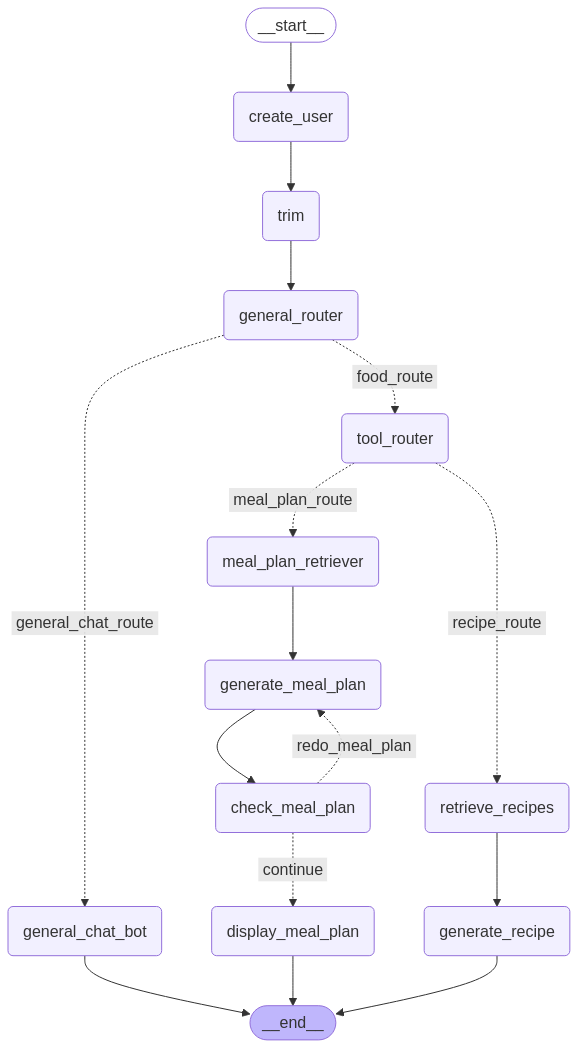

In [43]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("ERROR :(")
    pass

### Chat and testing

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
# input_message = [HumanMessage(content="Hey")]
# output = app.invoke({"messages":input_message},config=config)
# output["messages"][-1].pretty_print()

In [46]:
# input_message = [HumanMessage(content="How to make butter chicken"),
#                  HumanMessage(content="Help me createa meal plan for the week"),
#                  HumanMessage(content="What is the capital of France")]

input_message = [HumanMessage(content="Give me a recipe for chicken soup"),
                 HumanMessage(content="Could you make it spicier for me"),]

for input_m in input_message:
    output = app.invoke({"messages":input_m},config=config)
    output["messages"][-1].pretty_print()

reached general state
---ROUTE QUESTION (GENERAL)---
---ROUTE QUESTION TO FOOD---
reached food state
---ROUTE QUESTION (TOOLS)---
---ROUTE QUESTION TO RECIPE---
---RETRIEVE---
retrieved using the prompt:  Give me a recipe for chicken soup
---GENERATE RECIPE---
================================== Ai Message ==================================

Based on your preference for Indian vegetarian food, here's a delicious recipe for **Vegetable Curry Soup**, inspired by traditional Indian flavors:

### Vegetable Curry Soup

#### Ingredients:
- 2 tablespoons olive oil
- 1 medium onion, chopped
- 2 cloves garlic, minced
- 1-inch piece of ginger, minced
- 2 medium carrots, diced
- 1 cup cauliflower florets
- 1 cup green beans, chopped
- 1 medium potato, diced
- 1 can (14 oz) diced tomatoes
- 4 cups vegetable broth
- 1 can (14 oz) coconut milk
- 2 teaspoons curry powder
- 1 teaspoon turmeric powder
- 1 teaspoon cumin
- Salt and pepper to taste
- Fresh cilantro for garnish
- Lime wedges for serving

#